In [1]:
import random
import numpy as np
import matplotlib.pyplot as pt

from math import ceil
from typing import List, Tuple, Callable

In [2]:
def get_polynomial(x):
    return 5*x + 20*x**2 + 1*x**3

In [3]:
def get_dataset(number_of_samples, noise_scale) -> Tuple[np.ndarray]:
    x_rand = np.sort(25*(np.random.rand(number_of_samples, 1) - 0.8), -1).reshape((number_of_samples,))
    noise = (noise_scale*np.random.randn(number_of_samples, 1)).reshape((number_of_samples,))
    
    x = np.sort(x_rand)
    y = np.add(get_polynomial(x), noise)
    
    x_plot = np.linspace(x[0], x[-1], 100)
    y_plot = get_polynomial(x_plot)
    
    return (x, y, x_plot, y_plot, noise)

In [4]:
def plot_arbitrary_polynomial(x, coef, title: str = f"Polynomial"):
    x_plot = np.linspace(x[0], x[-1], 100)
    y_seq = np.zeros(len(x_plot))
    for i in range(len(coef)):
        y_seq = np.add(y_seq, coef[i]*x_plot**i)
    pt.plot(x_plot, y_seq)
    pt.title(title)
    pt.show()
                

In [5]:
def polyfit(x: np.array, y: np.array, order: int, title: str = None) -> Tuple[np.ndarray]:
    poly = np.polyfit(x, y, order, full=True)
    coefficients = poly[0]
    residuals = poly[1]
    pt.plot(x, y, 'ro')
    if title is not None:
        plot_arbitrary_polynomial(x, coefficients[::-1], title=title)
    else:
        plot_arbitrary_polynomial(x, coefficients[::-1], titlet=title)
    return (coefficients, residuals)

True polynomial: 1*x**3 + 20*x**2 + 5*x + 0


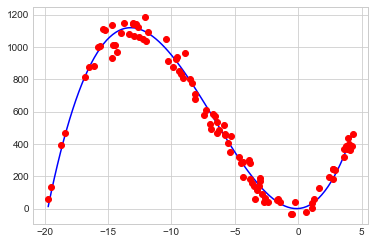

In [6]:
pt.style.use('seaborn-whitegrid')
print("True polynomial: 1*x**3 + 20*x**2 + 5*x + 0")
(x, y, x_plot, y_plot, noise) = get_dataset(100, 50)
pt.plot(x_plot, y_plot, 'b')
pt.plot(x, y, 'ro')

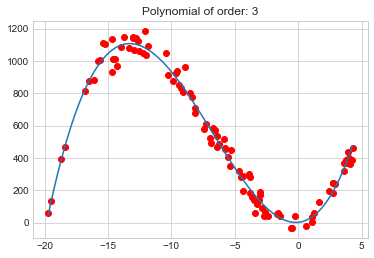

Function:  0.9842611395580602*x^3 + 19.891605879030973*x^2 + 7.31096351096582*x^1 + 1.2189682780935982*x^0 

Coefficients: [ 0.98426114 19.89160588  7.31096351  1.21896828]
Residuals: [244640.57682334]


In [7]:
mse: List[float] = []
order: List[int] = [3]
hw1_coefs = None
for m in order:
    (coef, res) = polyfit(x, y, m, title=f"Polynomial of order: {m}")
    hw1_coefs = np.flip(coef)
    function_string = ""
    for i in range(len(coef)):
        function_string += f" {coef[i]}*x^{len(coef)-i-1} "
        if i != len(coef)-1:
            function_string += '+'
    print(f"Function: {function_string}\n")
    print(f"Coefficients: {coef}")
    print(f"Residuals: {res}")
    mse += res.tolist()

In [8]:
class GeneticAlgorithm():
    def __init__(self, max_degree, population, max_init, mutation_rate, mutation_wiggle, crossover_rate):
        self.pop = np.random.random((population, max_degree+1)) * max_init
        self.crossover_rate = crossover_rate
        self.mutation_wiggle = mutation_wiggle 
        self.mutation_rate = mutation_rate
        
    def fit(self, x: np.ndarray, y: np.ndarray, loss: Callable, percent_kept_per_generation: float, threshold: float, max_iter: int):
        m, n = self.pop.shape
        self.best_coefs = np.zeros(n)
        self.best_loss = None
        # for each generation
        for generation in range(max_iter):
            print(f'generation: {generation}')
            # compute fitness of each baby and save it 
            loss_scores = np.zeros(m)
            for i in range(m):
                # get the coef for that child
                sample_coefs = self.pop[i, :]
                # calculate that childs fitness
                loss_scores[i] = loss(sample_coefs, x, y)
                #stop condition
                if loss_scores[i] <= threshold:
                    print(f'stopping condition: threshold on loss score {i}: {loss_scores[i]}')
                    self.best_coefs = sample_coefs
                    return
            
            best_coefs_index = np.argpartition(loss_scores, 1)[:1]
            self.best_coefs = self.pop[best_coefs_index, :]
            self.best_loss = loss_scores[best_coefs_index]
            
            # check how many children you're keeping per generation
            num_kept = int(m * percent_kept_per_generation)
            
            # find the num_kept with the minimum loss
            kept_ind = np.argpartition(loss_scores, num_kept)[:num_kept]

            # first, create the children as perfect copies of their parents
            new_generation = np.zeros_like(self.pop)
            new_gen_ind = np.array_split(np.arange(m), len(kept_ind))
            for i, ind_batch in enumerate(new_gen_ind):
                new_generation[ind_batch, :] = self.pop[kept_ind[i], :]

    #         if self.mutation_rate > 0:
            # randomly sample a percentage of them to mutate
            inds_to_mutate = np.random.randint(low=0, high=m, size=(ceil(m * self.mutation_rate),))
            # generate the coefficients we will 'wiggle' each coef by
            wiggle = np.random.uniform(low=self.mutation_wiggle[0], high=self.mutation_wiggle[1], size=(len(inds_to_mutate),))
            # generate the coefficient indices to mutate
            coef_inds_to_mutate = np.random.randint(low=0, high=n, size=(len(inds_to_mutate),))
            for i, ind_to_mutate in enumerate(inds_to_mutate):
                # randomly choose to wiggle a coefficient up or down
                if bool(random.getrandbits(1)):
                    new_generation[ind_to_mutate, coef_inds_to_mutate[i]] += new_generation[ind_to_mutate, coef_inds_to_mutate[i]]*wiggle[i]
                else:
                    new_generation[ind_to_mutate, coef_inds_to_mutate[i]] -= new_generation[ind_to_mutate, coef_inds_to_mutate[i]]*wiggle[i]                

    #         if self.crossover_rate > 0:
            # randomly sample a percentage of them to crossover
            num_to_crossover = ceil(m * self.crossover_rate) if ceil(m * self.crossover_rate) % 2 == 0 else ceil(m * self.crossover_rate) - 1
            inds_to_crossover = np.random.randint(low=0, high=m, size=(num_to_crossover,))
            crossover_ind_pairs = np.array_split(inds_to_crossover, num_to_crossover / 2)

            stop_index = int(n/2)
            for pair in crossover_ind_pairs:
                # grab the values
                sample1 = new_generation[pair[0], :]
                sample2 = new_generation[pair[1], :]

                # perform the swap
                temp = None
                temp = sample1[:stop_index].copy()
                sample1[:stop_index] = sample2[:stop_index]
                sample2[:stop_index] = temp

                # reset the values
                new_generation[pair[0], :] = sample1
                new_generation[pair[1], :] = sample2
                
            self.pop = new_generation            
        print('stopping condition: max_iter')
            
            

In [9]:
ga = GeneticAlgorithm(
    max_degree = 3,
    population = 1000,
    max_init = 50,
    mutation_rate = 0.01,
    mutation_wiggle = (0.0, 2.0),
    crossover_rate = 0.5
)

In [10]:
def loss(coef, x, y):
    def calc_poly_value(degree, x, coef):
        output = 0
        for i in range(degree):
            output += coef[i]*x**i
        return output
    
    values = np.zeros(len(x))
    for i in range(len(x)):
        values[i] = calc_poly_value(len(coef), x[i], coef)
    return abs(sum(y - values))
    
ga.fit(
    x, 
    y, 
    loss=loss, 
    percent_kept_per_generation=0.1, 
    threshold=800, 
    max_iter=500
)

best_coefs = ga.best_coefs
print(f"best coefs: {best_coefs}")

generation: 0
generation: 1
generation: 2
stopping condition: threshold on loss score 132: 222.86026757009319
best coefs: [36.85696503 14.41196728 19.01139074  0.9062793 ]


In [11]:
best_coefs

array([36.85696503, 14.41196728, 19.01139074,  0.9062793 ])

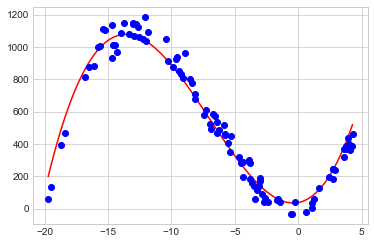

In [12]:
x_plot = np.linspace(min(x), max(x), 100)
y_seq = np.zeros(len(x_plot))
for i in range(len(best_coefs)):
    y_seq = np.add(y_seq, best_coefs[i]*x_plot**i)
pt.plot(x_plot, y_seq, 'r')
pt.plot(x, y, 'bo')
pt.show()

## Final plot with noisy input data, Genetic Algorithm Output, and HW1 Polyfit Output

In [15]:
# x_plot = np.linspace(x[0], x[-1], 100)
y_seq_hw1 = np.zeros(len(x_plot))
for i in range(len(hw1_coefs)):
    y_seq_hw1 = np.add(y_seq_hw1, hw1_coefs[i]*x_plot**i)

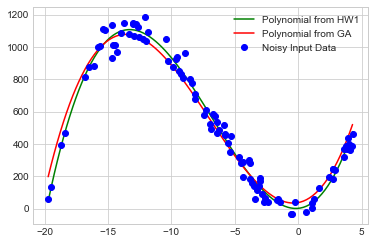

In [17]:
pt.plot(x_plot, y_seq_hw1, 'g')
pt.plot(x_plot, y_seq, 'r')
pt.plot(x, y, 'bo')
pt.legend(["Polynomial from HW1", "Polynomial from GA", "Noisy Input Data"])
pt.show()

In [20]:
print(f"Coefficients from HW1: {hw1_coefs}")
print(f"Coefficients from GA: {best_coefs}")

Coefficients from HW1: [ 1.21896828  7.31096351 19.89160588  0.98426114]
Coefficients from GA: [36.85696503 14.41196728 19.01139074  0.9062793 ]
